# Extraction

#### **TODO** - Create some function to simply dump the data into one or multiple csv files.
Decide on what format and what data this should include, e.g.:
- one csv file per treatment? 
- one csv file per dataset? 
- etc.

In [20]:
import os
import json
import pandas as pd

def load_experiment_data(directory):
    """
    Extracts experiment data from a particular directory filepath given as argument.

    Constructs dataframes holding statistical summary and individual measurements, 
    adds them to the corresponding `dict` using `<SESSION_NAME>` as the key.

    Returns: `dict`: summary_dataframes, `dict`: detailed_dataframes

    ---

    **Note 1**: omits "prevalence", "population", and "frequency_table" fields from 
    the <session_name>.json file and extracts only the statistical metrics.

    **Note 2**: this function can identify and handle multiple session files in 
    the same directory. 
    """

    # Dictionaries to store dataframes 
    # (this function supports loading multiple treatment data files from same dir)
    summary_dataframes = {}     # Statistical summary (<session_name>.json)
    detailed_dataframes = {}    # All individual data points (all_data_<session_name>.json)

    # Get all files in the given directory
    files = os.listdir(directory)

    # Find all session names based on filenames
    sessions = set()
    for file in files:
        # Find the files with only the "session" name
        if file.endswith(".json") and not file.startswith("all_data_"):
            session = file.replace(".json", "")
            # If the corresponding "all_data" file exists, add the session key
            if f"all_data_{session}.json" in files:
                sessions.add(session)

    # Load data for each session
    for session in sessions:
        # Concatenate file paths based on the session keys
        summary_path = os.path.join(directory, f"{session}.json")
        detail_path = os.path.join(directory, f"all_data_{session}.json")

        # Load summary statistics -> "<session_name>.json"
        with open(summary_path, "r") as f:
            summary_json = json.load(f)

        # Convert summary metrics to a dataframe
        # Note: this currently excludes "prevalence" and the "frequency_table"
        metric_rows = []
        for _, value in summary_json.items():
            # Only process dictionaries with a "name" field (i.e., metrics)
            if isinstance(value, dict) and "name" in value: 
                metric_rows.append({
                    # Adds metric key with the corresponding metric name as value,
                    # otherwise the resulting df has a "name" column instead of "metric"
                    "metric": value["name"], 
                    # Exclude unnecessary fields and flatten the dictionary
                    **{k: v for k, v in value.items() if k != "name" and k != "population"}
                })
        
        # Add the session dataframe to dictionary containing all sessions,
        # using the session name as key
        summary_df = pd.DataFrame(metric_rows)
        summary_dataframes[session] = summary_df

        # Load detailed individual measurements -> "all_data<session_name>.json"
        with open(detail_path, "r") as f:
            detail_json = json.load(f)

        # Add the detailed session data dataframe to the dictionary containing all sessions,
        # using the session name as key
        detail_df = pd.DataFrame(detail_json)
        detailed_dataframes[session] = detail_df

    return summary_dataframes, detailed_dataframes

Load data from all `../res` sub-directories:

In [21]:
summary_dfs = {}    # dict to store statistical summary data (<session_name>.json)
detail_dfs = {}     # dict to store all individual measurements (all_data_<session_name>.json)

base_dir = '../res' # directory generated by "eval.py", contains the .json files

iteration_structure = True # flag to signal the directory structure of the input data

def populate_dataframes(files_path):
    global summary_dfs, detail_dfs
    temp_sum_df, temp_det_df = load_experiment_data(files_path)

    # Append the new data to the dictionaries
    summary_dfs |= temp_sum_df
    detail_dfs |= temp_det_df

# Traverse all the sub-directories
for day in os.listdir(f"{base_dir}"):
    for timestamp in os.listdir(f"{base_dir}/{day}"):

        # If the experiment was run in iterations, 
        # there is an additional level of sub-directories to loop over
        if iteration_structure:
            for session in os.listdir(f"{base_dir}/{day}/{timestamp}"):

                # Skip current iteration if we encountered a file
                if not os.path.isdir(f"{base_dir}/{day}/{timestamp}/{session}"): continue

                # Construct the path to the current directory and load the data
                files_path = f"{base_dir}/{day}/{timestamp}/{session}"
                populate_dataframes(files_path)
        
        else:
            # Skip current iteration if we encountered a file
            if not os.path.isdir(f"{base_dir}/{day}/{timestamp}"): continue

            # Construct the path to the current directory and load the data
            files_path = f"{base_dir}/{day}/{timestamp}"
            populate_dataframes(files_path)
        

Print the loaded statistical summary dataframes:

In [22]:
#print(summary_dfs["test"])
#print("\n---")
#print(summary_dfs["bths"])
print(summary_dfs)

{'MIS_AWQ_BTHS':                     metric  size         total          min           q1  \
0                    all_n    10   1200.000000   120.000000   120.000000   
1                   all_tp    10     17.000000     1.000000     1.000000   
2                   all_tn    10   1000.000000   100.000000   100.000000   
3                   all_fp    10      0.000000     0.000000     0.000000   
4                   all_fn    10    183.000000    18.000000    18.000000   
5             all_accuracy    10      8.475000     0.841667     0.841667   
6    all_balanced_accuracy    10      9.226606     0.920168     0.920168   
7                   all_f1    10      1.558442     0.095238     0.095238   
8               all_recall    10      0.850000     0.050000     0.050000   
9            all_precision    10     10.000000     1.000000     1.000000   
10         all_specificity    10      8.453212     0.840336     0.840336   
11                 all_err    10      0.000000     0.000000     0.00000

Print the loaded measurement dataframes:

In [23]:
#print(detail_dfs["test-model"])
#print("\n---")
#print(detail_dfs["bths"])
print(detail_dfs)

{'MIS_AWQ_BTHS':                                    data_path  prevalence    n  tp   tn  fp  \
0  ./out/MIS_AWQ_BTHS/2025-04-28/22_58_14/01    0.166667  120   2  100   0   
1  ./out/MIS_AWQ_BTHS/2025-04-28/22_58_14/02    0.166667  120   2  100   0   
2  ./out/MIS_AWQ_BTHS/2025-04-28/22_58_14/03    0.166667  120   2  100   0   
3  ./out/MIS_AWQ_BTHS/2025-04-28/22_58_14/04    0.166667  120   1  100   0   
4  ./out/MIS_AWQ_BTHS/2025-04-28/22_58_14/05    0.166667  120   1  100   0   
5  ./out/MIS_AWQ_BTHS/2025-04-28/22_58_14/06    0.166667  120   2  100   0   
6  ./out/MIS_AWQ_BTHS/2025-04-28/22_58_14/07    0.166667  120   2  100   0   
7  ./out/MIS_AWQ_BTHS/2025-04-28/22_58_14/08    0.166667  120   2  100   0   
8  ./out/MIS_AWQ_BTHS/2025-04-28/22_58_14/09    0.166667  120   2  100   0   
9  ./out/MIS_AWQ_BTHS/2025-04-28/22_58_14/10    0.166667  120   1  100   0   

   fn  accuracy  balanced_accuracy        f1  recall  precision  specificity  \
0  18  0.850000           0.923729  0.181818

---

## Plotting & Visualization

#### **TODO** - the functions in this section are the first drafts. We need to decide on what we want and implement it.
- improve existing function or add new ones

#### Create MVP table
**Table Structure Example**:

| treatment     | accuracy      | recall | ...  |
|---------------|---------------|--------|------|
| Ollama-None   | (mean ± sd)   |        |      |
| Ollama-Q1     |               |        |      |
| Ollama-Q2     |               |        |      |
| Mixtral-None  |               |        |      |
| Mixtral-Q1    |               |        |      |
| ...           |               |        |      |

**Note**: *treatments* are derived from the session names (keys)

In [24]:
def format_mean_sd(mean, sd):
    """
    Formats mean and standard deviation as a string, 
    rounds to two decimal places and removes trailing zeros.

    Example: "3.1 ± 0.2"
    """
    # Note: values are converted to floats to we don't risk creating empty strings
    mean_str = f"{mean:.2f}".rstrip("0").rstrip(".")
    sd_str = f"{sd:.2f}".rstrip("0").rstrip(".")

    return f"{mean_str} ± {sd_str}"


def create_mvp_table_df(summary_dataframes: dict[str: pd.DataFrame]):
    """
    Creates a table with treatments as rows and metrics as columns,
    showing values as (mean +- standard deviation).
    """

    # Make a temporary copy so we don't modify the original data
    temp_dfs = summary_dataframes.copy()

    # Construct new dataframe with the treatment column populated with the session keys
    treatment_df = pd.DataFrame({"treatment": [key for key in temp_dfs]})
    
    # Dynamically constructs an empty dataframe with the metrics values as column names
    # Each row will hold the data of a session (treatment)
    metrics_df = pd.DataFrame(
            columns=[metrics for metrics in temp_dfs[next(iter(temp_dfs))]["metric"]]
        )
    
    # Iterate over each session key, construct new row with (mean ± sd) values for each metric
    # Note: concatenating dfs in a loop is technically inefficient (could construct using lists)
    #       but we will not have enough treatments for it to really matter.
    for session_key in temp_dfs:
        # Combine columns to create String representations of: mean ± standard deviation
        mean_and_sd = temp_dfs[session_key].apply(
                lambda row: format_mean_sd(row["mean"], row["sd"]), axis=1
            )

        # Convert series to dataframe so we can transpose from column to row
        mean_and_sd_df = mean_and_sd.to_frame().T

        # Copy the column names for easy concatenation
        mean_and_sd_df.columns = metrics_df.columns

        # Add the row to the metrics dataframe
        metrics_df = pd.concat([metrics_df, mean_and_sd_df], ignore_index=True)

    # Concatenate the treatment and metrics dataframes to create the final table
    combined_table_df = pd.concat([treatment_df, metrics_df], axis=1) # concatenates horizontally

    return combined_table_df
            

In [25]:
table_df = create_mvp_table_df(summary_dfs)

print(table_df)

        treatment     all_n       all_tp        all_tn     all_fp  \
0    MIS_AWQ_BTHS   120 ± 0   1.7 ± 0.46       100 ± 0      0 ± 0   
1    MIS_AWQ_ENCO  1640 ± 0  34.6 ± 0.49  1591.9 ± 0.3  2.1 ± 0.3   
2   MIS_AWQ_SNAKE   132 ± 0       10 ± 0       120 ± 0      2 ± 0   
3   MIS_NONE_BTHS   120 ± 0   3.2 ± 0.98       100 ± 0      0 ± 0   
4   MIS_NONE_ENCO  1640 ± 0       35 ± 0      1593 ± 0      1 ± 0   
5  MIS_NONE_SNAKE   132 ± 0       10 ± 0       119 ± 0      3 ± 0   

        all_fn all_accuracy all_balanced_accuracy       all_f1   all_recall  \
0  18.3 ± 0.46     0.85 ± 0              0.92 ± 0  0.16 ± 0.04  0.08 ± 0.02   
1  11.4 ± 0.49     0.99 ± 0              0.97 ± 0  0.84 ± 0.01  0.75 ± 0.01   
2        0 ± 0     0.98 ± 0              0.92 ± 0     0.91 ± 0        1 ± 0   
3  16.8 ± 0.98  0.86 ± 0.01              0.93 ± 0  0.27 ± 0.07  0.16 ± 0.05   
4       11 ± 0     0.99 ± 0              0.98 ± 0     0.85 ± 0     0.76 ± 0   
5        0 ± 0     0.98 ± 0              0

**Plot MVP table [WIP]**

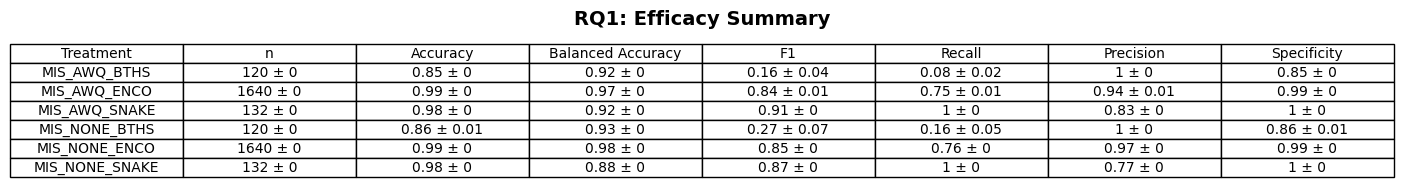

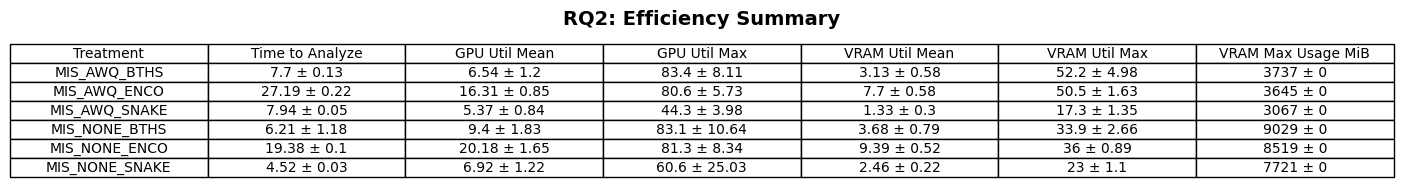

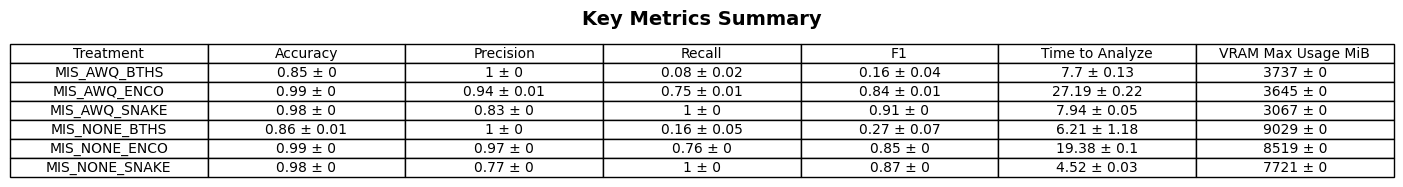

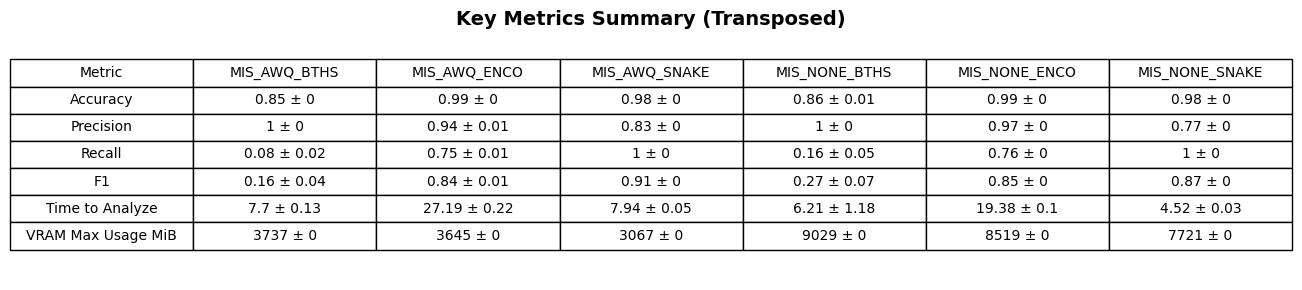

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

def prettify_col(col):
    """
    Clean up and prettify the column names.
    """
    col = col.replace("all_", "").replace("_", " ")
    words = col.split()
    return " ".join( # inserts a space character between concatenated strings
        (
            w.upper() if w.lower() in {"tp", "tn", "fp", "fn", "f1", "gpu", "vram"} # all caps for acronyms
            else "MiB" if w.lower() == "mib" # MiB needs special capitalization
            else w if w.lower() in {"n", "to"} # lowercase for sample size and "to" in "Time-to-Analyze"
            else w.title() # title capitalization if multi-word
        )
        for w in words
    )

def plot_table(df, title, figsize=(14, 2), title_pad=20):
    _, ax = plt.subplots(figsize=figsize)
    ax.axis("off")
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     loc="center",
                     cellLoc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    plt.title(title, fontsize=14, fontweight="bold", pad=title_pad)
    plt.tight_layout()
    plt.show()

# "TP", "TN", "FP", "FN",
efficacy_cols = ["Treatment", "n", "Accuracy", "Balanced Accuracy", "F1", "Recall", "Precision", "Specificity"]
efficiency_cols = ["Treatment", "Time to Analyze", "GPU Util Mean", "GPU Util Max", "VRAM Util Mean", "VRAM Util Max", "VRAM Max Usage MiB"]
key_metrics_cols = ["Treatment", "Accuracy", "Precision", "Recall", "F1", "Time to Analyze", "VRAM Max Usage MiB"]

copy_df = table_df.copy()

copy_df.columns = [prettify_col(col) for col in copy_df.columns]

df_main = copy_df[efficacy_cols]
df_resource = copy_df[efficiency_cols]
df_most_interesting = copy_df[key_metrics_cols]

plot_table(df_main, "RQ1: Efficacy Summary")
plot_table(df_resource, "RQ2: Efficiency Summary")
plot_table(df_most_interesting, "Key Metrics Summary")

# Transposed version: treatments as column names
transposed_df = df_most_interesting.set_index("Treatment").T.reset_index()
transposed_df.columns = ["Metric"] + list(transposed_df.columns[1:])

plot_table(transposed_df, "Key Metrics Summary (Transposed)", figsize=(13, 3), title_pad=0)

**Output dataframe to Latek format [WIP]**

In [27]:
# Make copy to keep original dataframe intact
latex_df = table_df.copy()

# Fix column names
latex_df.columns = [prettify_col(col) for col in latex_df.columns]

# Replace the special character "±" with its latex equivalent and wrap values in math mode
for col in latex_df.columns:
    if col != "Treatment":
        latex_df[col] = latex_df[col].apply(
            lambda x: "$" + str(x).replace("±", "\\pm") + "$"
        )

# TODO: column names out-of-date
latex_mvp_table = latex_df.to_latex(
    index=False, 
    columns=[
        "Treatment", 
        "Accuracy", 
        "Balanced Accuracy", 
        "F1", 
        "Recall", 
        "Precision", 
        "Time To Analyze", 
        "Memory Usage"
        ]
    )

#print(latex_df.columns)
print(latex_mvp_table)

\begin{tabular}{llllll}
\toprule
Treatment & Accuracy & Balanced Accuracy & F1 & Recall & Precision \\
\midrule
MIS_AWQ_BTHS & $0.85 \pm 0$ & $0.92 \pm 0$ & $0.16 \pm 0.04$ & $0.08 \pm 0.02$ & $1 \pm 0$ \\
MIS_AWQ_ENCO & $0.99 \pm 0$ & $0.97 \pm 0$ & $0.84 \pm 0.01$ & $0.75 \pm 0.01$ & $0.94 \pm 0.01$ \\
MIS_AWQ_SNAKE & $0.98 \pm 0$ & $0.92 \pm 0$ & $0.91 \pm 0$ & $1 \pm 0$ & $0.83 \pm 0$ \\
MIS_NONE_BTHS & $0.86 \pm 0.01$ & $0.93 \pm 0$ & $0.27 \pm 0.07$ & $0.16 \pm 0.05$ & $1 \pm 0$ \\
MIS_NONE_ENCO & $0.99 \pm 0$ & $0.98 \pm 0$ & $0.85 \pm 0$ & $0.76 \pm 0$ & $0.97 \pm 0$ \\
MIS_NONE_SNAKE & $0.98 \pm 0$ & $0.88 \pm 0$ & $0.87 \pm 0$ & $1 \pm 0$ & $0.77 \pm 0$ \\
\bottomrule
\end{tabular}

